In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# Introduction to the Project
In this notebook, we are going to address the data preparation and the EDA analysis for the challenge presented in the [kaggle](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data)

# Downloading the Data
We begin with download the data using our API key from the kaggle website (you need an account for it.)

In [2]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
files.upload()

{}

In [ ]:
# Create the kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set the correct permissions
!chmod 600 ~/.kaggle/kaggle.json

# List the available datasets in the competition
!kaggle competitions files -c favorita-grocery-sales-forecasting

# Download the dataset
!kaggle competitions download -c favorita-grocery-sales-forecasting

We then save the downloaded file in our google colab and extract the zipped file.

In [4]:
!pip install py7zr
import py7zr
import os
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/retail_kaggle_data
!cp favorita-grocery-sales-forecasting.zip /content/drive/MyDrive/retail_kaggle_data/.

folder_path = "/content/drive/MyDrive/retail_kaggle_data/"
extracted_path = os.path.join(folder_path)

os.makedirs(extracted_path, exist_ok=True)

# Loop through all .csv.7z files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv.7z"):
        full_path = os.path.join(folder_path, filename)
        with py7zr.SevenZipFile(full_path, mode='r') as archive:
            archive.extractall(path=extracted_path)

In case you run this notebook from a local platform such as VSCode or Pycharm, place the kaggle.json file in the main folder of the project and run the following code snippet

In [ ]:
import os
!pip install py7zr
import py7zr
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Step 1: Move kaggle.json to the correct location
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
os.rename("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# Step 2: Authenticate and download the dataset
api = KaggleApi()
api.authenticate()

# Download zip to local project folder
project_data_folder = "./retail_kaggle_data/"
os.makedirs(project_data_folder, exist_ok=True)

# Download dataset
api.competition_download_files("favorita-grocery-sales-forecasting", path=project_data_folder)

# Step 3: Unzip the downloaded archive
zip_path = os.path.join(project_data_folder, "favorita-grocery-sales-forecasting.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(project_data_folder)

# Step 4: Extract all .csv.7z files
for filename in os.listdir(project_data_folder):
    if filename.endswith(".csv.7z"):
        full_path = os.path.join(project_data_folder, filename)
        with py7zr.SevenZipFile(full_path, mode='r') as archive:
            archive.extractall(path=project_data_folder)

print("Dataset downloaded and extracted!")

# Loading the Data
Having saved the raw data, we can now import all the datasets.

In [5]:
# Load the CSV files into pandas DataFrames
from google.colab import drive
drive.mount('/content/drive')

df_stores = pd.read_csv(folder_path + 'stores.csv')
df_items = pd.read_csv(folder_path + 'items.csv')
df_transactions = pd.read_csv(folder_path + 'transactions.csv')
df_oil = pd.read_csv(folder_path + 'oil.csv')
df_holidays_events = pd.read_csv(folder_path + 'holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv(folder_path + 'train.csv', nrows=2e6)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us explore each dataset

In [ ]:
df_items.head(5)
# df_stores.head(5)
# df_transactions.head(5)
# df_oil.head(5)
# df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


# Preprocessing
From here on, we start the data manipulation to prepare the data for trainign the model and answering our business questions.

## Stores per Region
Let us begin with identifying the number of stores we have in each region.

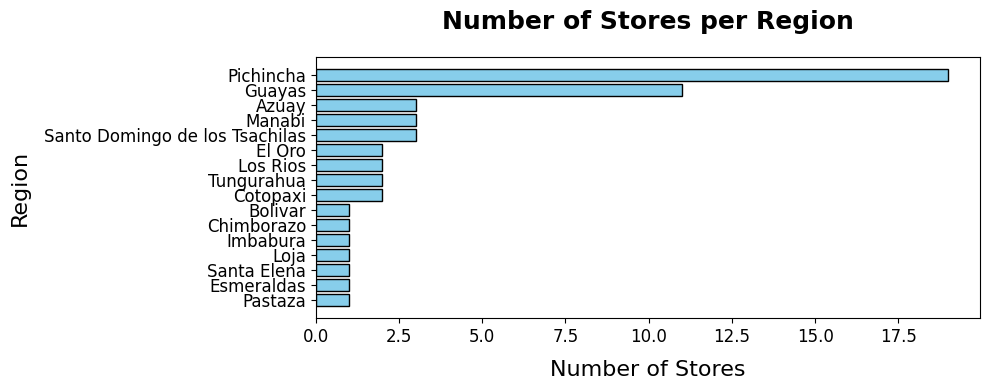

In [6]:
# Plotting the number of stores per region (state)
# Count the number of stores per region and sort in ascending order
stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

# Plot the sorted data
plt.figure(figsize=(10, 4))  # Increase figure size for better readability
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')  # Use horizontal bar plot
# Titles and labels with enhanced formatting
plt.title("Number of Stores per Region", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=16, labelpad=10)
plt.ylabel("Region", fontsize=16, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# Display the plot
plt.show()

Two regions have most of the stores: "Pichincha" and "Guayas". Here we use stores from "Pichincha" to illustrate the concepts.

In [7]:
# Select list of stores located in the 'Pichincha' region
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()

We then load the data for Pichancha region in chunks to avoid memory overload

In [8]:
# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv(folder_path + 'train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-8-d4c7c23f2bf3>:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(folder_path + 'train.csv', chunksize=chunk_size):


Let's look at the shape of the data now:

In [12]:
df_train.shape

(54550923, 6)

## Items Family
The dataset that we have is still very big even after filtering. To prevent our work from unexpected crashes, we will further reduce the size by limiting ourselves to certain families of items sold. Let us take a look on the existing families of items.

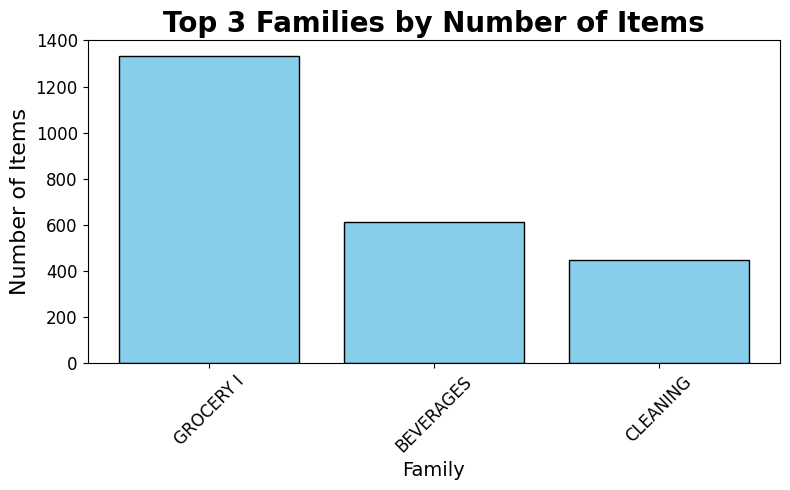

In [13]:
# Plotting the number of items per family (for top 10 families only)
# Compute the number of items per family and select the top 10 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
# top_10_families = items_per_family.head(10)  # Keep only the top 10 families
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 10 families
plt.figure(figsize=(8, 5))
# plt.bar(top_10_families['Family'], top_10_families['Item Count'], color='skyblue', edgecolor='black')
# plt.title("Top 10 Families by Number of Items", fontsize=18, fontweight='bold')
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=14)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
# Display the plot
plt.show()

We only keep the top 10 families of items:

In [14]:
# item_ids = df_items[df_items['family'].isin(top_10_families['Family'].unique())]['item_nbr'].unique()
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
# df_items['item_nbr'].nunique(),len(item_ids)
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

Let's check the shape now:

In [15]:
df_train.shape

(34066408, 6)

From around 54.5 millions of rows to around 34 mil. This is our reduction.

## Missing Values
We could now start looking for the missing/incorrect values to treat.

In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,8932678


The onpromotion column has NaNs. Let's replace them with `False`

In [ ]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

Outliers are next. Let's first work with the negative sales:

In [ ]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Viewing negative sales for analysis
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


And now replace negative sales with 0s:

In [ ]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

Next, we are going to use the function for the z-score calculatuion to calculate the Z-score for each store-item.

In [ ]:
# Function to compute Z-scores within each (store_nbr, item_nbr) group
def add_z_scores(group: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 'z_score' column to the group based on 'unit_sales'.
    If std deviation is zero, uses 1 to avoid division by zero.
    """
    mean = group['unit_sales'].mean()
    std = group['unit_sales'].std() or 1  # Avoid division by zero
    group['z_score'] = (group['unit_sales'] - mean) / std
    return group

# Apply Z-score calculation to each store-item group
df_train = df_train.groupby(['store_nbr', 'item_nbr']).apply(add_z_scores).reset_index(drop=True)

Or in a more compact manner we can write:

In [ ]:
# Add Z-score column for each (store_nbr, item_nbr) group in one line
df_train['z_score'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']\
    .transform(lambda x: (x - x.mean()) / (x.std() if x.std() != 0 else 1))

Great, now we can define the threshold for the z-score and detect outliers:

In [ ]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train[df_train['z_score'] > 5]
outliers

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400
...,...,...,...,...,...,...,...
14741488,114286905,2017-05-01,51,2048609,48.0,False,7.830664
14742765,104195298,2017-01-25,51,2054291,21.0,False,6.141217
14743164,122354227,2017-07-16,51,2057033,21.0,True,5.247882
14743658,117045510,2017-05-27,51,2058907,12.0,False,5.054512


There are many of these values but they don't look like errors. These are just big sales.

## Date Column
Next, let's work with zero-sales that we might have for particular item-store combinations and for particualr dates:

In [ ]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


Ok, now we have a list of all dates between the min and max date in our dataset! Next, let's create a DataFrame with all (store, item, date) combinations

In [ ]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


and now we are finally ready to fill up the original data with missing dates by merging two dataframes::

In [ ]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,False
1,24,105574,2013-01-03,59692.0,1.0,False
2,24,105574,2013-01-04,99664.0,3.0,False
3,24,105574,2013-01-05,140805.0,4.0,False
4,24,105574,2013-01-06,182800.0,7.0,False


Now we have all dates and corresponding sales for them. Let's replace the original dataframe:

In [ ]:
df_train = df_filled
del df_filled

Next, let's go and do engineering similar to what we did on Campus:

In [ ]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [ ]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [ ]:
df_train.head(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,NaN
5,24,105574,2013-01-07,223895.0,3.0,False,2013,1,7,0,NaN
6,24,105574,2013-01-08,263107.0,3.0,False,2013,1,8,1,4.714286
7,24,105574,2013-01-09,302232.0,7.0,False,2013,1,9,2,4.000000
8,24,105574,2013-01-10,341031.0,3.0,False,2013,1,10,3,4.285714
9,24,105574,2013-01-11,379570.0,6.0,False,2013,1,11,4,4.714286


Look, for the first days we have no values in the `'unit_sales_7d_avg'` column. This is because we used the window size that is equal to 7

We are all done with data preprocessing & features generation. EDA comes next! It is going to be similar to what we did on Campus for Pichincha. Let's start with total sales over time:

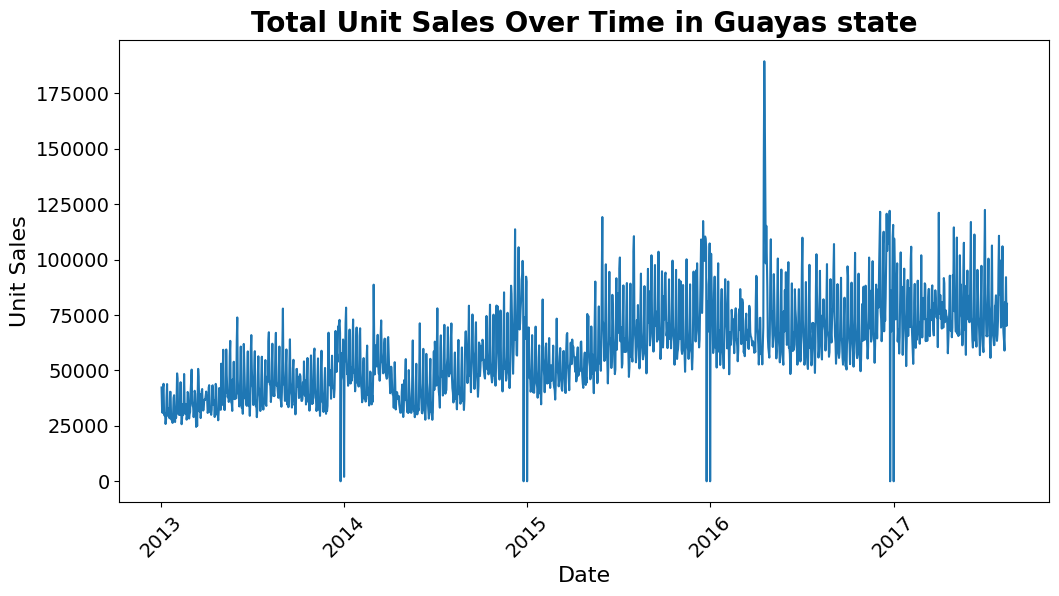

In [ ]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

Next, we'll look at monthly sales:

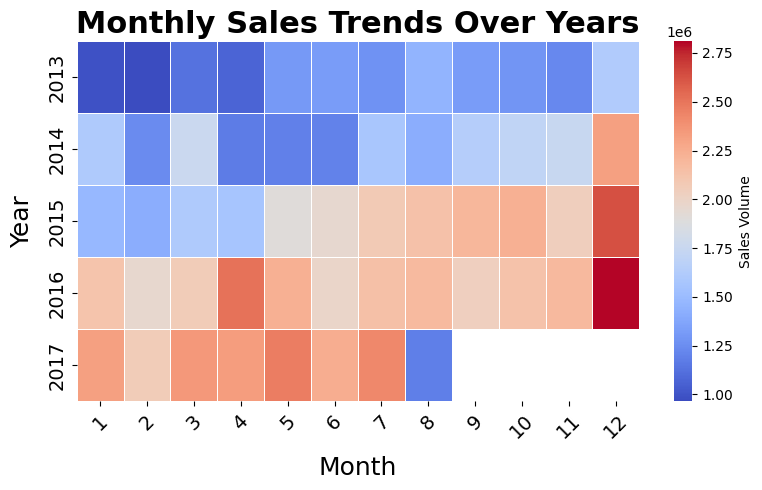

In [ ]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

What about the impact of holidays?

In [ ]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


To look at the impact of holidays, let's exclude day with zero sales like it was at the verr beginning:

In [ ]:
df_train_no_zero = df_train[df_train.unit_sales > 0]

In [ ]:
# Merging df_train with zero sales with data with holidays
df_train_holiday = pd.merge(df_train_no_zero, df_holidays_events, on='date', how='left')

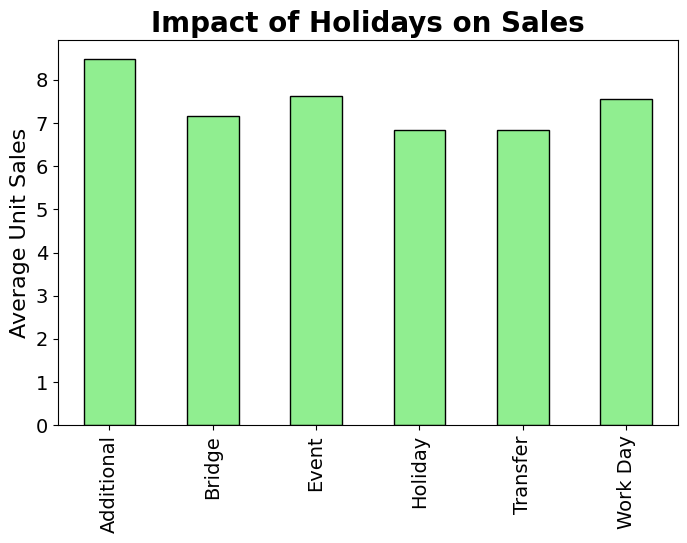

In [ ]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Next, please proceed further from here and do some extra EDA of your choice!

Don't forget to save your notebook and the resulting cleaned dataset to GitHub repo at the end!

## First Item Sell
A typical challenge in time series forecasting is how to predict demand for item, which does not have a sales history yet? Here one needs to make sure attributes for items are used in the model, to help it identify patterns for similar items in data.

Let us explore this effect in our dataset.

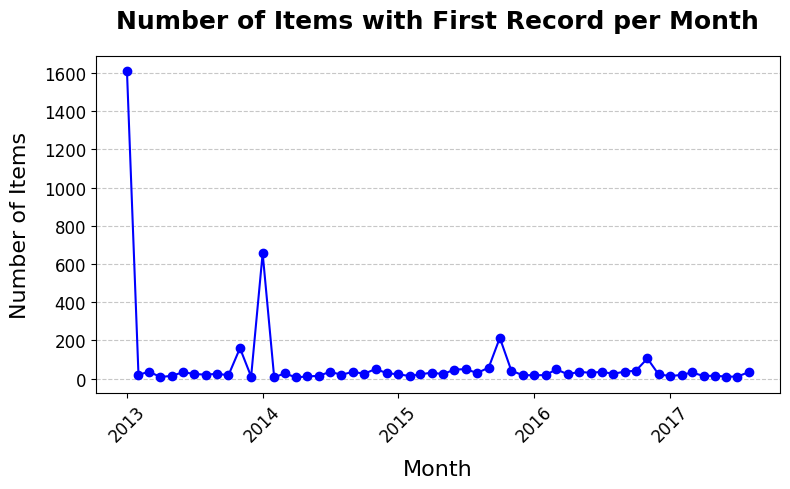

In [11]:
# Identify the first record for each item by date
# Ensure the date column is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
first_record_per_item = df_train.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month and count items for each month
first_record_per_item['YearMonth'] = first_record_per_item['date'].dt.to_period('M')
items_per_month = first_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
items_per_month['YearMonth'] = items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(items_per_month['YearMonth'], items_per_month['Item Count'], marker='o', linestyle='-', color='b')  # Line plot with markers

# Add titles and labels
plt.title('Number of Items with First Record per Month', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=16, labelpad=10)
plt.ylabel('Number of Items', fontsize=16, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

## Connection To External Factors
Some countries economy are very sensetive to external factors such as gold/gas/oil price. Ecuadors economy may be also one of those economies. Let us see if that is true.

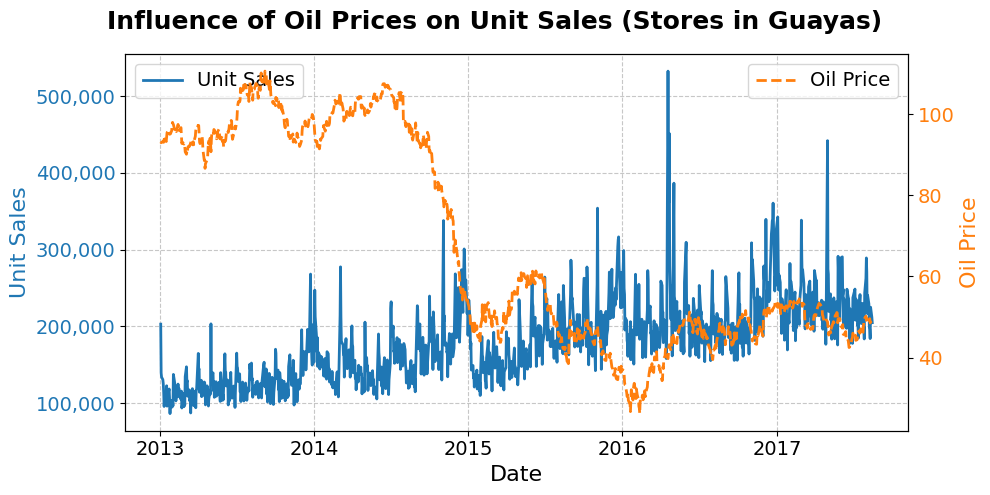

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Ensure datetime formats for merging and plotting
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')

# Rename columns for clarity
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['oil_price'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Unit Sales', fontsize=16, color='tab:blue')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Format y-axis for unit sales
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', fontsize=16, color='tab:orange')
ax2.plot(merged_data['date'], merged_data['oil_price'], label='Oil Price', color='tab:orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Stores in Guayas)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In total sales where is very no direct influence of oil prices visible. But for single products it might be different. Therefore in the modeling we should try adding lag features related to oil prices.